<h3>Dependencies</h3>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


<h3>Hyper parameters</h3>

In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [4]:
def sampling(params):
    z_mean, z_log_var = params
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [5]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

<h3>Instantiate these layers for later use</h3>

In [7]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

<h3>Variational autoencoder and its loss function</h3>

In [8]:
vae = Model(x, x_decoded_mean)

In [9]:
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

In [10]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

<h3>Split the data for train and test</h3>

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

<h3>Training the model</h3>

In [12]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 163us/step - loss: 192.1720 - val_loss: 172.9743
Epoch 2/50
60000/60000 [==============================] - 8s 130us/step - loss: 170.2964 - val_loss: 167.1653
Epoch 3/50
60000/60000 [==============================] - 8s 137us/step - loss: 165.9816 - val_loss: 164.1466
Epoch 4/50
60000/60000 [==============================] - 8s 125us/step - loss: 163.1778 - val_loss: 161.5718
Epoch 5/50
60000/60000 [==============================] - 8s 133us/step - loss: 161.1489 - val_loss: 160.0471
Epoch 6/50
60000/60000 [==============================] - 8s 132us/step - loss: 159.7391 - val_loss: 158.8432
Epoch 7/50
60000/60000 [==============================] - 8s 135us/step - loss: 158.7108 - val_loss: 158.2243
Epoch 8/50
60000/60000 [==============================] - 8s 126us/step - loss: 157.9222 - val_loss: 157.4305
Epoch 9/50
60000/60000 [==============================] - 8s 125us/st

<h3>State encoder and decoder stages</h3>

In [13]:
encoder = Model(x, z_mean)

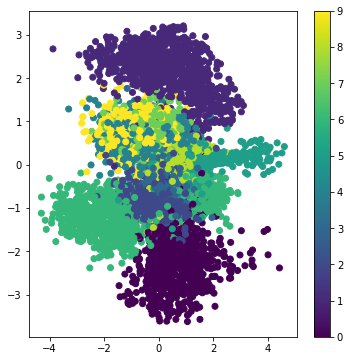

In [14]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [15]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

<h3>Finally, ready to generate own images</h3>

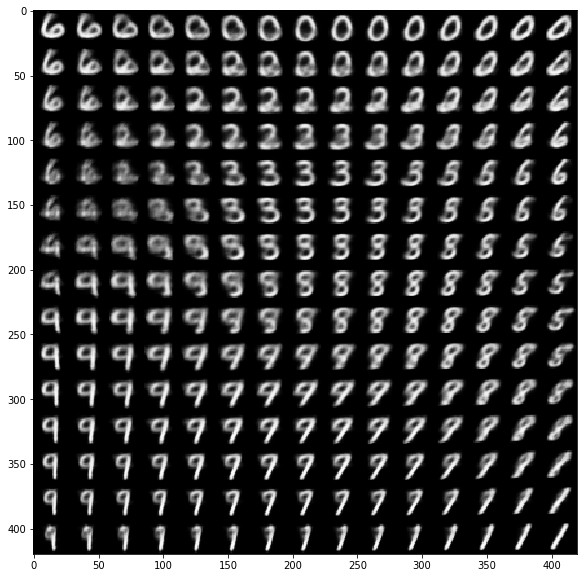

In [16]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()